# Sleep Apena

一如往常先 load Module and Function，以及 read image

In [21]:
import os                            # 與當按路徑建置、開啟相關的模組
import numpy as np                   # 與矩陣計算相關的模組
import pandas as pd                  # 用來整理資料表格或做前處理始用的模組
import matplotlib.pyplot as plt      # 用來做圖使用的模組
import cv2                           # 做影像前處理所需要的模組--opencv，此處簡稱 cv2
import time
from tqdm import tqdm                # 進度視覺化函數

# 資料集載入、再觀察與處理

In [2]:
train_csv = pd.read_csv("sleep_data_v2/train.csv", index_col=False)
test_csv = pd.read_csv("sleep_data_v2/test.csv", index_col=False)

In [3]:
train_path = "./sleep_data_v2/Mel_train"  # 指定訓練集的讀檔路徑
train_data=[]                                                      # 先宣告一個空的 list 承接檔案
for eachfile in train_csv["Number"]:                               # 用 for 迴圈將檔案名稱一個個唱名
    image = cv2.imread(os.path.join(train_path, eachfile+".png"))  # 被唱到名的檔案就會和訓練集路徑用 os.path.join 結合
                                                                   # 用 cv2.imread 將檔案開啟
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                 # 由於 cv2 開檔讀進來的是 BGR 所以我們將其轉成 RGB
    train_data.append(image)                                       # 將開啟的檔案放到 train_data 中

In [4]:
test_path = "./sleep_data_v2/Mel_test"
test_data=[]
for eachfile in test_csv["Number"]:
    image = cv2.imread(os.path.join(test_path, eachfile+".png"))    
    #print(eachfile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_data.append(image)

In [5]:
sleep_type = {0:"Normal", 1:"Sick"}

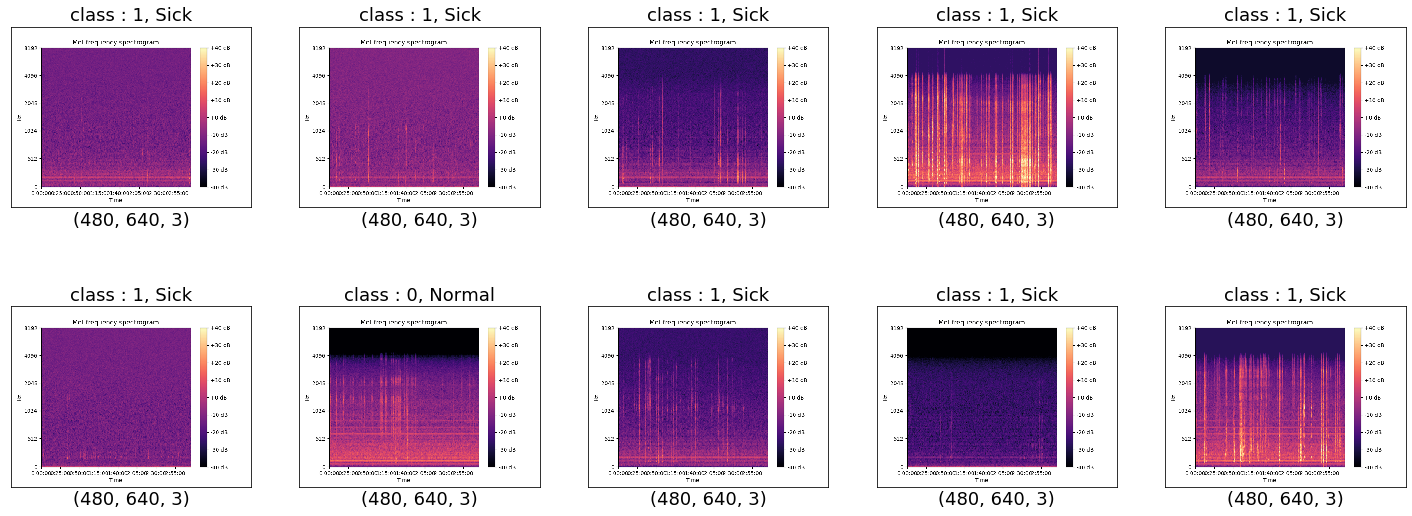

In [6]:
plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
for i in range(10):
    ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置
    plt.title("class : "+str(train_csv["Label"][i] )+", "+str(sleep_type[train_csv["Label"][i]]), 
               fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
    plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
    plt.yticks([])
    ax.set_xlabel(test_data[i].shape,fontsize=18) 
    ax.imshow(train_data[i])                                       # 將指定的影像放入呼叫的畫圖位置

In [7]:
from utils.image_processing_v2 import my_processing
# my_preprocessing(
#                  dataset,     # 放入開完檔案的影像進此函述做前處理 
#                  outsize,     # output 時的 image size
#                  pre_type     # 希望做什麼樣的特徵強化，共有["ori", "his", "cla", "gau"]四種可以填入
#                  )

In [8]:
pre_train = my_processing(dataset = train_data, outsize=456, pre_type="his")
pre_test  = my_processing(dataset = test_data, outsize=456, pre_type="his")
# outsize 設定 456 是為了放入底下模型所指定的 size
#20191205
print(train_data[0].shape)
print(pre_train[0].shape)
del train_data
del test_data

100%|██████████| 20/20 [00:00<00:00, 424.68it/s]

(480, 640, 3)
(456, 456, 3)


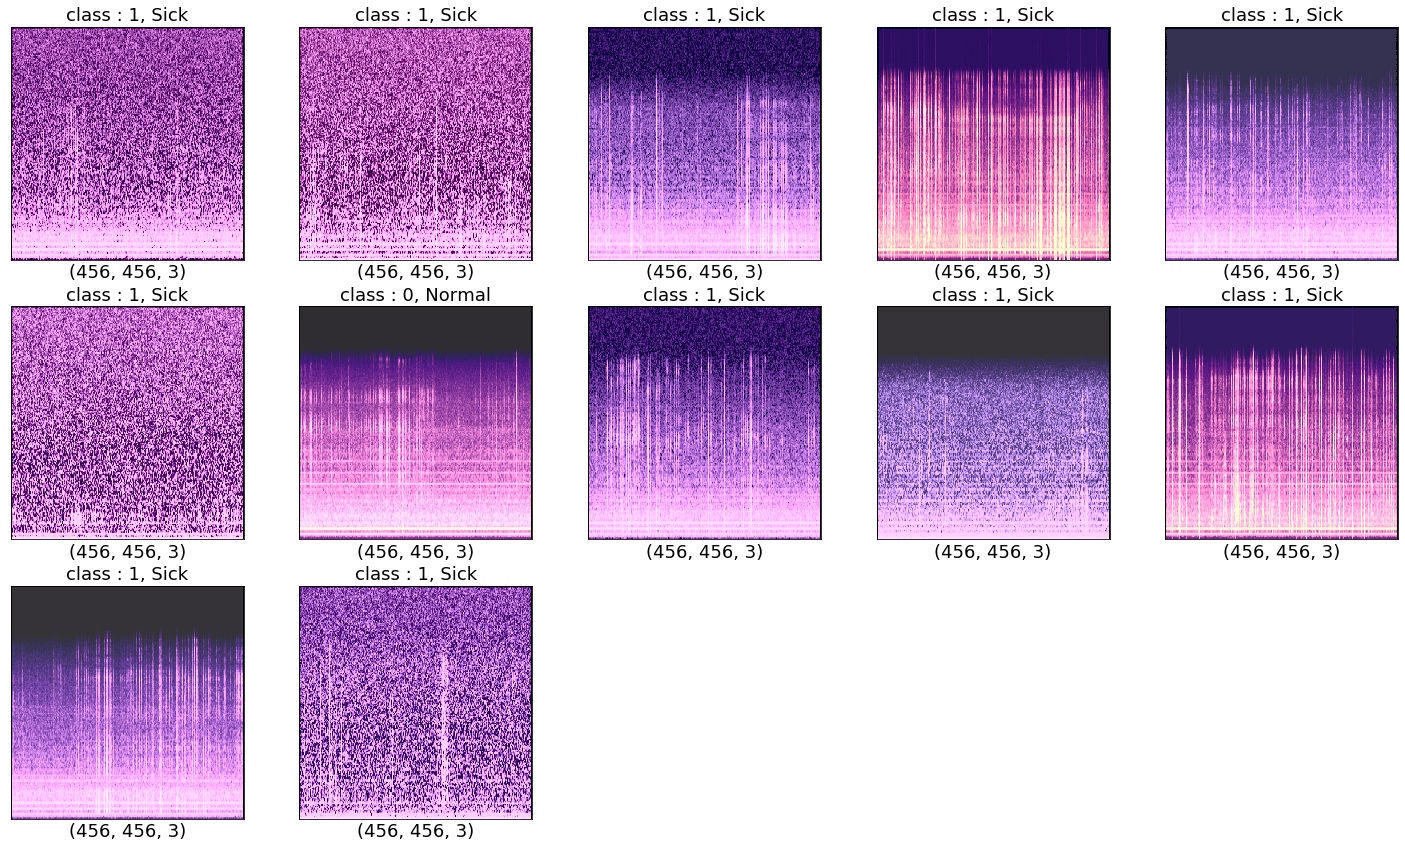

In [9]:
plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
for i in range(12):
    ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置
    plt.title("class : "+str(train_csv["Label"][i] )+", "+str(sleep_type[train_csv["Label"][i]]), 
               fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
    plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
    plt.yticks([])
    ax.set_xlabel(pre_train[i].shape, fontsize=18)
    ax.imshow(pre_train[i])                                       # 將指定的影像放入呼叫的畫圖位置

Train_Test_Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_valid, Y_train, Y_valid = train_test_split( pre_train, 
                                                       train_csv['Label'].values,
                                                       test_size=0.1, 
                                                       random_state=10,
                                                       stratify= train_csv['Label'].values)

# 如何改善預測成效?
## 1. 資料方面: 增加資料量
## 2. 模型方面: 調參、改模型結構
## 3. 訓練方面: Optimizer, loss function, transfer learning

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Input, Dense, GlobalAveragePooling2D)
from keras.optimizers import SGD, Adam
#from efficientnet import EfficientNetB5, preprocess_input
#from efficientnet.keras import EfficientNetB5, preprocess_input
from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [13]:
X_train = np.array([preprocess_input(image) for image in X_train])
X_valid = np.array([preprocess_input(image) for image in X_valid])
test_pred  = np.array([preprocess_input(image) for image in pre_test])

### Imbalance Data

In [14]:
from sklearn.utils import class_weight
classweight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
classweights = { 0: classweight[0], 1: classweight[1] }
print(classweights)

{0: 3.5294117647058822, 1: 0.5825242718446602}


對類別取一個比例，依照比例去增加其對應的資料之資料量，一般我們直接以複製資料做為增加的方式 (此例中我們選此法)<br>
![Imgur](https://i.imgur.com/LbxlfS3.jpg?1)

In [15]:
# X_train_prod = X_train.copy()
# Y_train_prod = Y_train.copy()

# # 不同 label 補不同倍數的值
# task = {0:9,1:2}
# for i in range(2):
#     tmp_x = X_train[Y_train==task[i]].copy()
#     tmp_y = Y_train[Y_train==task[i]].copy()
#     for j in range(task[i]):
#         X_train_prod = np.concatenate([X_train_prod, tmp_x])
#         Y_train_prod = np.concatenate([Y_train_prod, tmp_y])

### Data Augmentation  資料增強

In [16]:
datagen = ImageDataGenerator(
                                width_shift_range = 0.0,     # 水平平移
                                height_shift_range = 0.0,    # 垂直平移
                                rotation_range = 0,        # 0-180 任一角度旋轉
                                horizontal_flip = True,      # 任意水平翻轉
                                vertical_flip = True,        # 任意垂直翻轉
                                fill_mode = "constant",      # 在旋轉或平移時，有空隙發生，則空隙補常數
                                cval = 0                     # 設定常數值為 0
                             )

In [17]:
base_model = DenseNet201(weights='imagenet',include_top=False)

pool = GlobalAveragePooling2D()(base_model.output) 

output = Dense(2, activation='softmax')(pool)

model = Model(inputs = base_model.input, outputs = output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
#from keras.utils import plot_model
#plot_model(base_model, to_file='./outputs/DenseNet201_model.png')    # 畫畫模型圖

In [19]:
base_model.trainable = False
learning_rate = 1e-4
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

### 開始訓練

In [22]:
st_time = time.time()
batch_sizes = 4
num_epoch = 50
step_size_train = len(X_train)//batch_sizes
model_history = model.fit_generator(
                                    datagen.flow(X_train, np.eye(2)[Y_train], batch_size=batch_sizes),
                                    steps_per_epoch = step_size_train,
                                    validation_data = (X_valid, np.eye(2)[Y_valid]),
                                    epochs=num_epoch, verbose=1,
                                    class_weight = classweights
                                    )
end_time = time.time()
print(f"Execute time: {end_time-st_time} secs")

Epoch 1/50
30/30 [==============================] - 177s 6s/step - loss: 0.8578 - accuracy: 0.6750 - val_loss: 0.6180 - val_accuracy: 0.8571
Epoch 2/50
30/30 [==============================] - 134s 4s/step - loss: 0.6448 - accuracy: 0.6417 - val_loss: 0.3899 - val_accuracy: 0.7857
Epoch 3/50
30/30 [==============================] - 133s 4s/step - loss: 0.7273 - accuracy: 0.7000 - val_loss: 0.4164 - val_accuracy: 0.7143
Epoch 4/50
30/30 [==============================] - 132s 4s/step - loss: 0.5407 - accuracy: 0.6667 - val_loss: 0.4188 - val_accuracy: 0.8571
Epoch 5/50
30/30 [==============================] - 132s 4s/step - loss: 0.4894 - accuracy: 0.7417 - val_loss: 0.7580 - val_accuracy: 0.7857
Epoch 6/50
30/30 [==============================] - 131s 4s/step - loss: 0.4671 - accuracy: 0.7333 - val_loss: 0.6257 - val_accuracy: 0.6429
Epoch 7/50
30/30 [==============================] - 131s 4s/step - loss: 0.3727 - accuracy: 0.8250 - val_loss: 0.5008 - val_accuracy: 0.7143
Epoch 8/50
30

### 繪出訓練結果

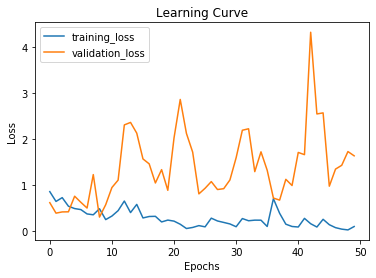

In [23]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
#model.save("./saved_models/DesNet201_model.h5")

# 用測試集評估成效

In [24]:
y_test = [x for x in test_csv['Label']]
results = model.evaluate(test_pred, np.eye(2)[y_test])
print(f'test loss, test acc: {results}')     

20/20 [==============================] - 6s 276ms/step
test loss, test acc: [0.44793590903282166, 0.800000011920929]


In [25]:
pred = model.predict(test_pred)
pred

array([[9.9862814e-01, 1.3719153e-03],
       [1.4864609e-03, 9.9851352e-01],
       [5.9439617e-06, 9.9999404e-01],
       [8.1099445e-01, 1.8900554e-01],
       [1.7168789e-04, 9.9982834e-01],
       [9.9204999e-01, 7.9500424e-03],
       [5.0781286e-01, 4.9218720e-01],
       [3.5559165e-04, 9.9964440e-01],
       [9.9581969e-01, 4.1803061e-03],
       [9.7205453e-02, 9.0279454e-01],
       [7.7174050e-01, 2.2825944e-01],
       [8.8804439e-02, 9.1119564e-01],
       [9.3246280e-04, 9.9906760e-01],
       [1.2842894e-01, 8.7157106e-01],
       [2.1902850e-01, 7.8097153e-01],
       [2.4639349e-04, 9.9975365e-01],
       [6.8485878e-02, 9.3151414e-01],
       [6.1707664e-01, 3.8292336e-01],
       [9.0534097e-01, 9.4659045e-02],
       [9.4306171e-03, 9.9056935e-01]], dtype=float32)

In [26]:
pred = pred.argmax(-1)
print(pred)
print(y_test)

[0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1]
[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
print(accuracy_score(y_test, pred))                          # 觀看準確率
print(confusion_matrix(y_test, pred))                        # 可以看出實際和預測的分布
print(cohen_kappa_score(y_test, pred, weights='quadratic'))  # 衡量不平衡且類別關係為強弱對應關係的一種衡量方式

0.8
[[ 4  0]
 [ 4 12]]
0.5454545454545454


In [ ]:
test_csv.loc[:,"Label"] = pred
test_csv.to_csv("./outputs/sleep_apnea_DenseNet201_predict.csv", index=False)